In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, dataloader
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from datagen import *
from analysis import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()

Running on GPU:  cuda:0
Running on GPU:  cuda:0


## Model

100%|██████████| 4000/4000 [02:21<00:00, 28.19it/s]


Last training time steps: 81
Losses array was not a multiple of average. Truncated to 3990


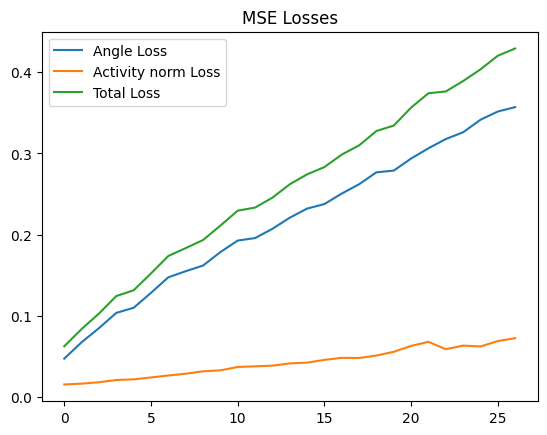

In [11]:
hidden_size = 128
input_size = 1
nav_size = 1

model1 = RNN_circular_LowEtAl_bridged(input_size,hidden_size,lr=0.0001,irnn=True,outputnn=False,Wx_normalize=False,activation=True,bias=False,nav_space=1,batch_size=64).to(device)

train = True

if train:
    _ = model1.train_gradual(epochs=4000)
    # model1.base_training_tsteps = 50
    # _ = model1.train(epochs=2000)
    model1.plot_losses(average=30)
else:
    model1.load_state_dict(torch.load("../trained models/LowEtAl_bridged_reduced_Gradual_lossiequaloroverj_maskonangle_lossscale_4000gradual.pt"))

# torch.save(model1.state_dict(), "../trained models/LowEtAl_bridged_reduced_Gradual_lossiequaloroverj_maskonangle_lossscale_4000gradual.pt")

In [4]:
_ = model1.train(epochs=10)

100%|██████████| 10/10 [00:01<00:00,  9.28it/s]


## Analysis

### Norm of activity per timestep

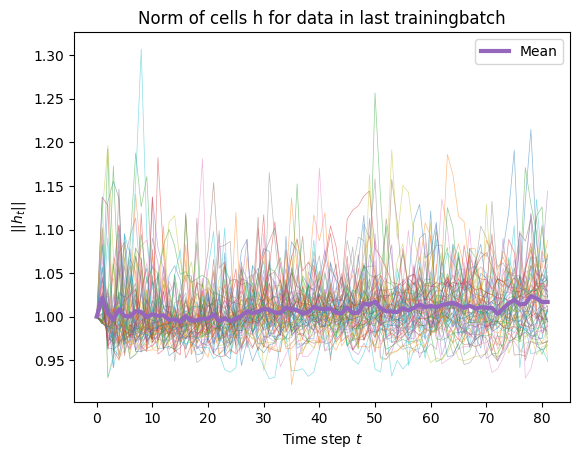

Mean norm:  1.0070702


In [12]:
htss = model1.hts.norm(dim=2)
htss = htss.cpu().detach().numpy()
plot_norm(htss,avg_only=False)

### Tuning curves

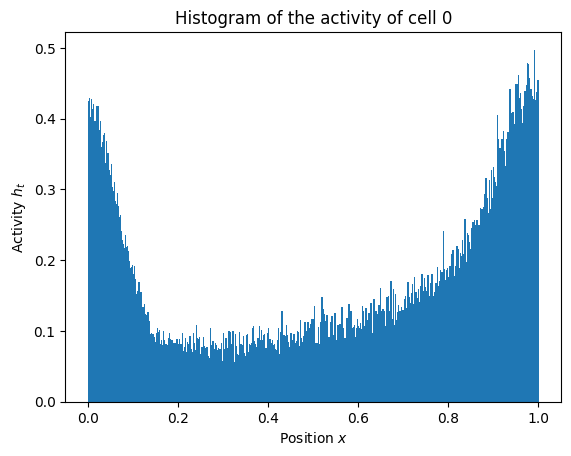

  0%|          | 0/4 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

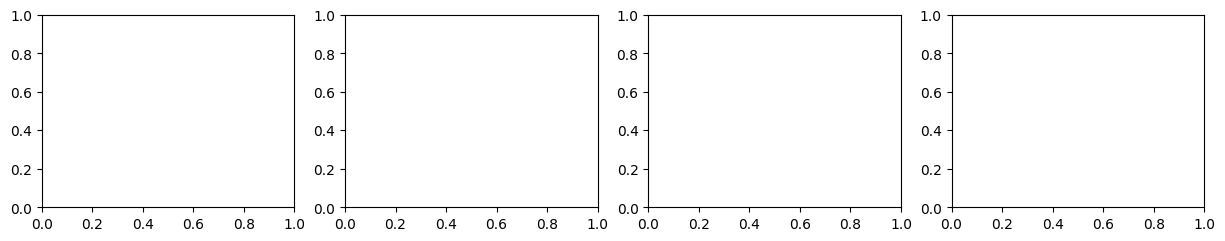

In [19]:
activity, bin_edges = tuning_curve(model1)
plot_tuning_curve(activity,bin_edges,0,spherical=False,linear=True,scale_to_one=True, plot_head_frac=1/32)

### Low dimensional representations

Explained variance for PCA with 2 components: 0.9242449542837653 %


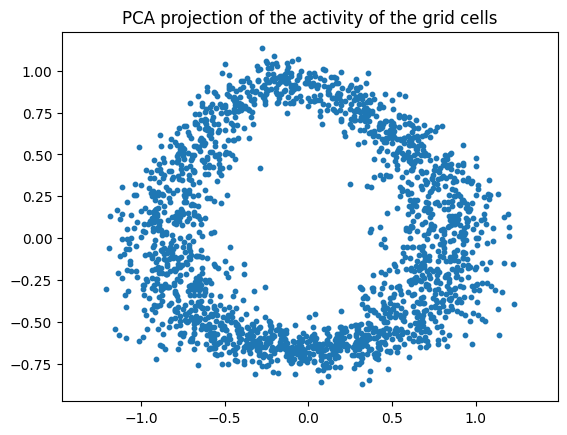

In [14]:
embedding, reducer = lowD_reduce(activity,if_pca=True,n_components=2,plot=True)

### Accuracy testing

In [15]:
angs, dy, err, y_hat, y = test_angle_inference(model1,reducer)


Mean error:  0.12142007338330336


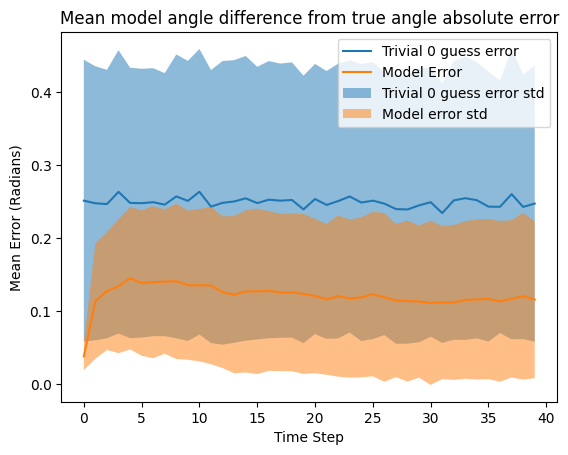

In [16]:
plot_accuracy(angs,dy,y_hat,y)

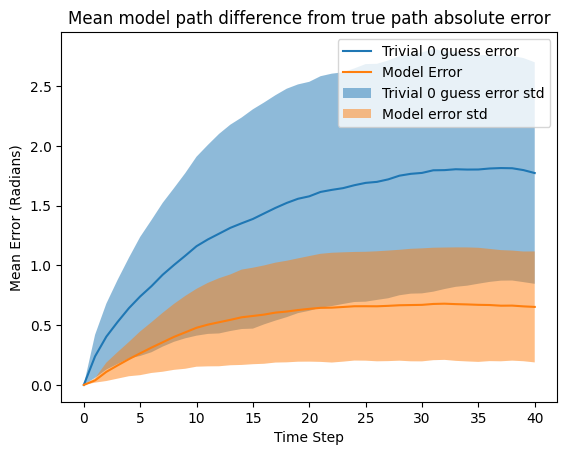

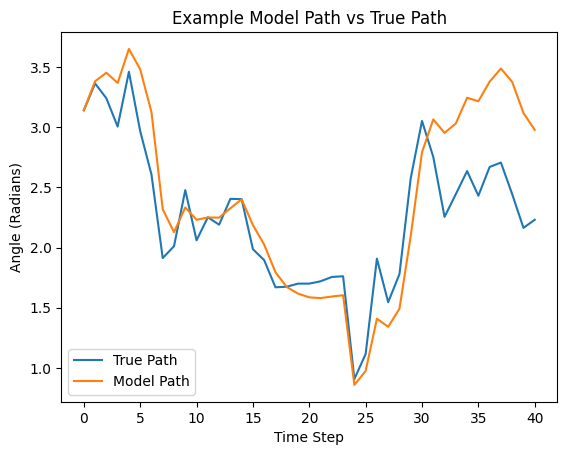

In [17]:
plot_path_accuracy(angs,y,example_path=0)